20.0
(500, 3, 128)


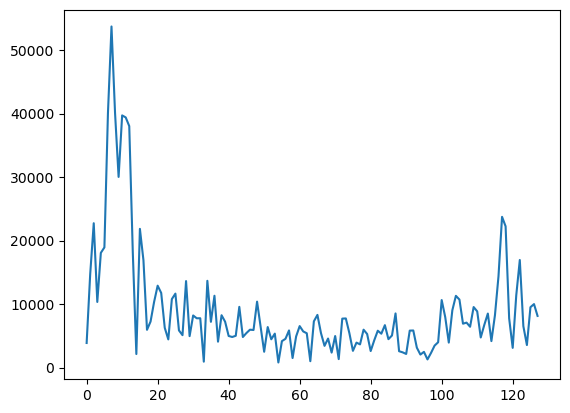

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq



################## Uncomment one of the following loading operations to observe that collection ###########################
# rawData = np.load("data_12_07_2023_00_46_18.npy") # simplistic breathing no episode
# rawData = np.load("data_12_07_2023_11_28_10.npy") # sleep apnea episode detection example start = 14, end = 17
# rawData = np.load("data_12_07_2023_13_34_50.npy") # sleep apnea episode detection human example start = 25, end = 31
# rawData = np.load("data_12_16_2023_14_31_47.npy") # sleep apnea episode regular breathing rate of 5 seconds start = 17.5, end = 21
# rawData = np.load("data_12_16_2023_14_52_22.npy") # sleep apnea episode slow breathing rate of 7 seconds start = 18.46, end = 22.89
# rawData = np.load("data_12_16_2023_14_48_51.npy") # sleep apnea episode fast breathing rate of 3 seconds start = 17.5, end = 21
# rawData = np.load("data_12_16_2023_15_47_36.npy") # sleep apnea episode regular breathing rate of 5 seconds start = 17.5, end = 21 down feather blanket
# rawData = np.load("data_12_16_2023_16_17_25.npy") # sleep apnea episode regular breathing rate of 5 seconds start = 17.5, end = 21 polyester blanket




# Update the following parameters according to the start and end comments
episode_start_time = 17.5
episode_end_time = 21

burst_periodicity = 50
episode_length = episode_end_time - episode_start_time
frames_per_second = 1/(burst_periodicity*10**(-3))
print(frames_per_second)



data = np.array([frame["adcSamples"][:, 128:] for frame in rawData])
full_data = np.array([frame["adcSamples"][:, :] for frame in rawData])
print(data.shape) # chirp* rx * samples per chirp

# Code for creating range profiles per frame in order to identify that we are picking up an object well

# print(data[0][0])

first_frame = full_data[0][0]
# frequencies = fftfreq(len(first_frame), d=(1.0 / len(first_frame)))
fft_result = fft(first_frame)

# split the result in half before plotting

fft_result = np.abs(fft_result)
fft_result = fft_result[:len(fft_result)//2]

plt.plot(range(len(fft_result)), np.abs(fft_result), label='range profile frame 1')
plt.show()






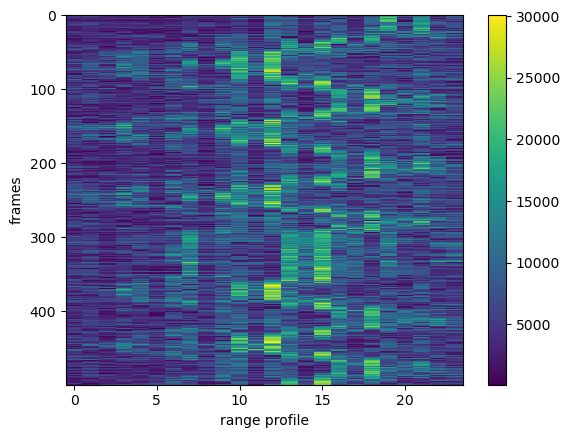

In [2]:
# create the range profiles

range_profiles = []

for frame_idx in range(len(data)):
    fft_result = fft(data[frame_idx][0])
    
    fft_result_mag = np.abs(fft_result)
    # fft_result_mag = fft_result_mag[:128]
    fft_result_mag = fft_result_mag[:len(fft_result_mag)//2]

    # print(fft_result_mag)

    range_profiles.append(fft_result_mag)

# print(vRange)


range_profiles = [profile[40:] for profile in range_profiles]
plt.imshow(np.array(range_profiles), cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xlabel("range profile")
plt.ylabel("frames")
plt.show()

# plt.plot(range(len(range_profiles[0])), np.abs(range_profiles[0]), label='range profile frame 1')
# plt.show()

maximums: [ 11 111 195 275 408 472]
minimums: [ 59 151 237 367 441]


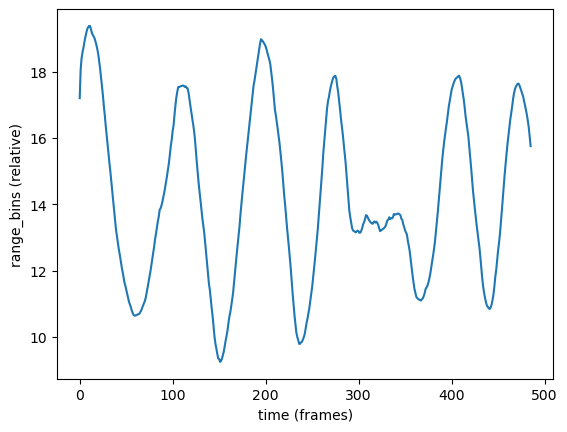

In [3]:
from scipy.ndimage import median_filter
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
range_bins = []

def kalman_filtering(measurements):
    ### kalman filtering ###

    # Define the system model
    F = 1  # State transition matrix
    H = 1  # Measurement matrix
    B = 0  # Control input matrix
    Q = 0.01  # Process noise covariance
    R = 0.1  # Measurement noise covariance
    
    # Initial state estimate and covariance
    x_hat = 0
    P = 1
    
    # Number of iterations
    num_iterations = 50
    
    # Kalman filter loop
    filtered_states = []
    for z_k in measurements:
        # Prediction
        x_hat_minus = F * x_hat
        P_minus = F * P * F + Q
    
        # Measurement update
        K = P_minus * H / (H * P_minus * H + R)
        x_hat = x_hat_minus + K * (z_k - H * x_hat_minus)
        P = (1 - K * H) * P_minus
    
        # Save filtered state
        filtered_states.append(x_hat)
    return filtered_states

def moving_average(data, window_size):
    moving_averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        average = sum(window) / window_size
        moving_averages.append(average)
    return moving_averages

def find_min_max_scipy(data, order):
    minima = argrelextrema(data, np.less, order=order, mode="wrap")[0]
    maxima = argrelextrema(data, np.greater, order=order, mode="wrap")[0]
    # return list(zip(minima, data[minima])), list(zip(maxima, data[maxima]))
    return list(minima), list(maxima)

for profile in range_profiles:
    # max_idx = np.argmax(profile)
    # peaks.append(max_idx)
    peaks, _ = find_peaks(profile,height=np.max(profile)*.8)
    if len(peaks) == 0:
        range_bins.append(range_bins[-1])
        continue
    range_bins.append(np.mean(peaks))


# range_bins = median_filter(range_bins, size=10)
range_bins = moving_average(range_bins, 15)

range_bins = kalman_filtering(range_bins)


plt.plot(range(len(range_bins)), range_bins)
plt.xlabel("time (frames)")
plt.ylabel("range_bins (relative)")

# minima, maxima = find_min_max_scipy(np.array(range_bins), 5 )

# print("minima:", minima)
# print("maxima:", maxima)

negated_range_bins = [-1*num for num in range_bins]

maxs, _ = find_peaks(range_bins, distance=5, prominence = 1.5)
mins, _ = find_peaks(negated_range_bins, distance=5, prominence = 1.5)


print("maximums:", maxs)
print("minimums:", mins)


max values: [ 11 111 195 275 408 472]
min values: [ 59 151 237 367 441]
max outliers:  [(275, 408), (408, 472)]
min_outliers: [(237, 367), (367, 441)]
positions:  [275, 408]
flat points:  [289 290 291 292 293 294 295 296 303 306 307 308 309 310 311 312 313 314
 318 319 320 321 322 323 326 329 330 331 333 334 335 336 337 338 339 341]
start:  294
end: 346
relative start time error:  0.16000000000000003
relative end time error 0.17619047619047615
relative length error 0.25714285714285673


Text(0, 0.5, 'range_bins (relative)')

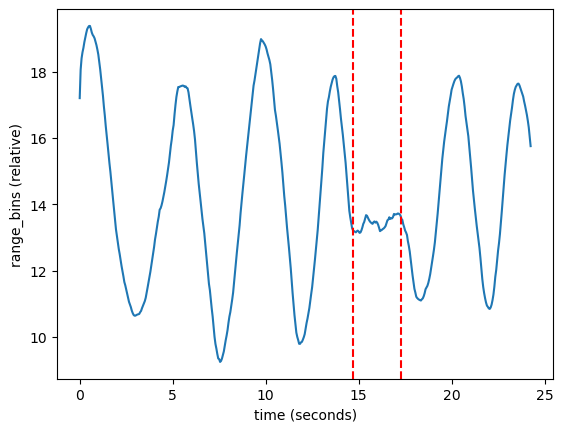

In [4]:
def is_outlier(value, data, threshold=2):
    mean = np.mean(data)
    std_dev = np.std(data)
    z_score = (value - mean) / std_dev
    return abs(z_score) > threshold
    
def avg_distance(data):
    dist = []
    outliers = []
    for i in range(len(data) - 1):
        dist.append(abs(data[i]-data[i+1]))

    for i in range(len(dist)):
        if is_outlier(dist[i], dist, 1):
            # print("outlier found between ", data[i], " and ", data[i+1])
            outliers.append((data[i], data[i+1]))
    return outliers


def remove_outliers(data, threshold=1.5):
    # Calculate the first and third quartiles (Q1 and Q3)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    cleaned_data = []
    for i in range(len(data)):
        if lower_bound <= data[i] <= upper_bound:
            cleaned_data.append(data[i])
    return cleaned_data

print("max values:",maxs)
print("min values:",mins)

max_outliers = avg_distance(maxs)
min_outliers = avg_distance(mins)

print("max outliers: ", max_outliers)
print("min_outliers:", min_outliers)

outliers = min_outliers + max_outliers

if len(outliers) == 0:
    print("There are no episodes detected. The following crash is expected.")
    quit()

diff = 0
diff_idx = -1
for i in range(len(outliers)):
    start, end = outliers[i]
    if (end - start) > diff:
        diff = end - start
        diff_idx = i
min, max = outliers[diff_idx]



    
positions = [min, max]
print("positions: ", positions)

ignored_frames = 5
y_range = range_bins[min+ignored_frames:max+1 - ignored_frames]

flat_threshold = .05  # for determining flatness
flat_point = np.where(np.abs(np.diff(y_range)) < flat_threshold)
new_list = flat_point[0]
cleaned_flat_points = remove_outliers(new_list, threshold=.7)

if len(cleaned_flat_points) < 2:
    adjusted_min = min
    adjusted_max = max
else:
    adjusted_min = min + ignored_frames + cleaned_flat_points[0]
    adjusted_max = min + ignored_frames + cleaned_flat_points[-1]

print("flat points: ", cleaned_flat_points+min)


print("start: ", adjusted_min)
print("end:", adjusted_max)

positions = [adjusted_min, adjusted_max]


### Evaluation ###

pred_start_time = adjusted_min/frames_per_second
pred_end_time = adjusted_max/frames_per_second

rel_start_err = np.abs(pred_start_time - episode_start_time)/episode_start_time
rel_end_err = np.abs(pred_end_time - episode_end_time)/episode_end_time
rel_length_err = np.abs((pred_end_time - pred_start_time) - episode_length)/episode_length


print("relative start time error: ", rel_start_err)
print("relative end time error", rel_end_err)
print("relative length error", rel_length_err)

### End Evaluation ###

frames = range(len(range_bins))
seconds = [frame / 20 for frame in frames]

plt.plot(seconds, range_bins)

for position in positions:
    plt.axvline(x=position/20, color='red', linestyle='--', label=f'Line at {position}')


# plt.fill_betweenx(range_bins, positions[0], positions[1],where=(x >= positions[0]) & (x <= positions[-1]), color='yellow', alpha=0.3, label='Between Line 1 and Line 2')
plt.xlabel("time (seconds)")
plt.ylabel("range_bins (relative)")
